In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import ticker
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [31]:
from IPython.display import Markdown, display, Image

In [32]:
sales = pd.read_csv("../data/train.csv", index_col=[0])
scaler = MinMaxScaler(feature_range=(-1,1))
sales.head()

# sales.drop("Open")


sales=sales.query('Open != 0')

sales=sales.groupby("Date")[["Sales"]].mean()

sales["Sales"]=np.round(sales["Sales"])

display(sales)


D:\Users\same\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
D:\Users\same\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Sales
Date,
2013-01-01,5720.0
2013-01-02,6255.0
2013-01-03,5724.0
2013-01-04,5992.0
2013-01-05,5376.0
...,...
2015-07-27,9620.0
2015-07-28,8190.0
2015-07-29,7637.0


In [33]:
scaler.fit(sales.Sales.values.reshape([-1, 1]))
salesScaled = scaler.transform(sales.Sales.values.reshape(-1, 1))
sales['SalesScaled'] = salesScaled
sales.tail(10)

,Sales,SalesScaled
Date,,
2015-07-22,5490.0,-0.720871
2015-07-23,6008.0,-0.619262
2015-07-24,5931.0,-0.634366
2015-07-25,5410.0,-0.736563
2015-07-26,8933.0,-0.045508
2015-07-27,9620.0,0.089251
2015-07-28,8190.0,-0.191251
2015-07-29,7637.0,-0.299725
2015-07-30,7906.0,-0.246960


In [35]:
import pickle
pickle.dump(scaler, open("../models/lstmScaler.pkl", 'wb'))

In [36]:
sales.describe()

,Sales,SalesScaled
count,942.000000,942.000000
mean,7253.936306,-0.374865
std,1759.830392,0.345200
min,4067.000000,-1.000000
25%,5781.250000,-0.663741
50%,7055.500000,-0.413790
75%,8046.500000,-0.219400
max,14263.000000,1.000000


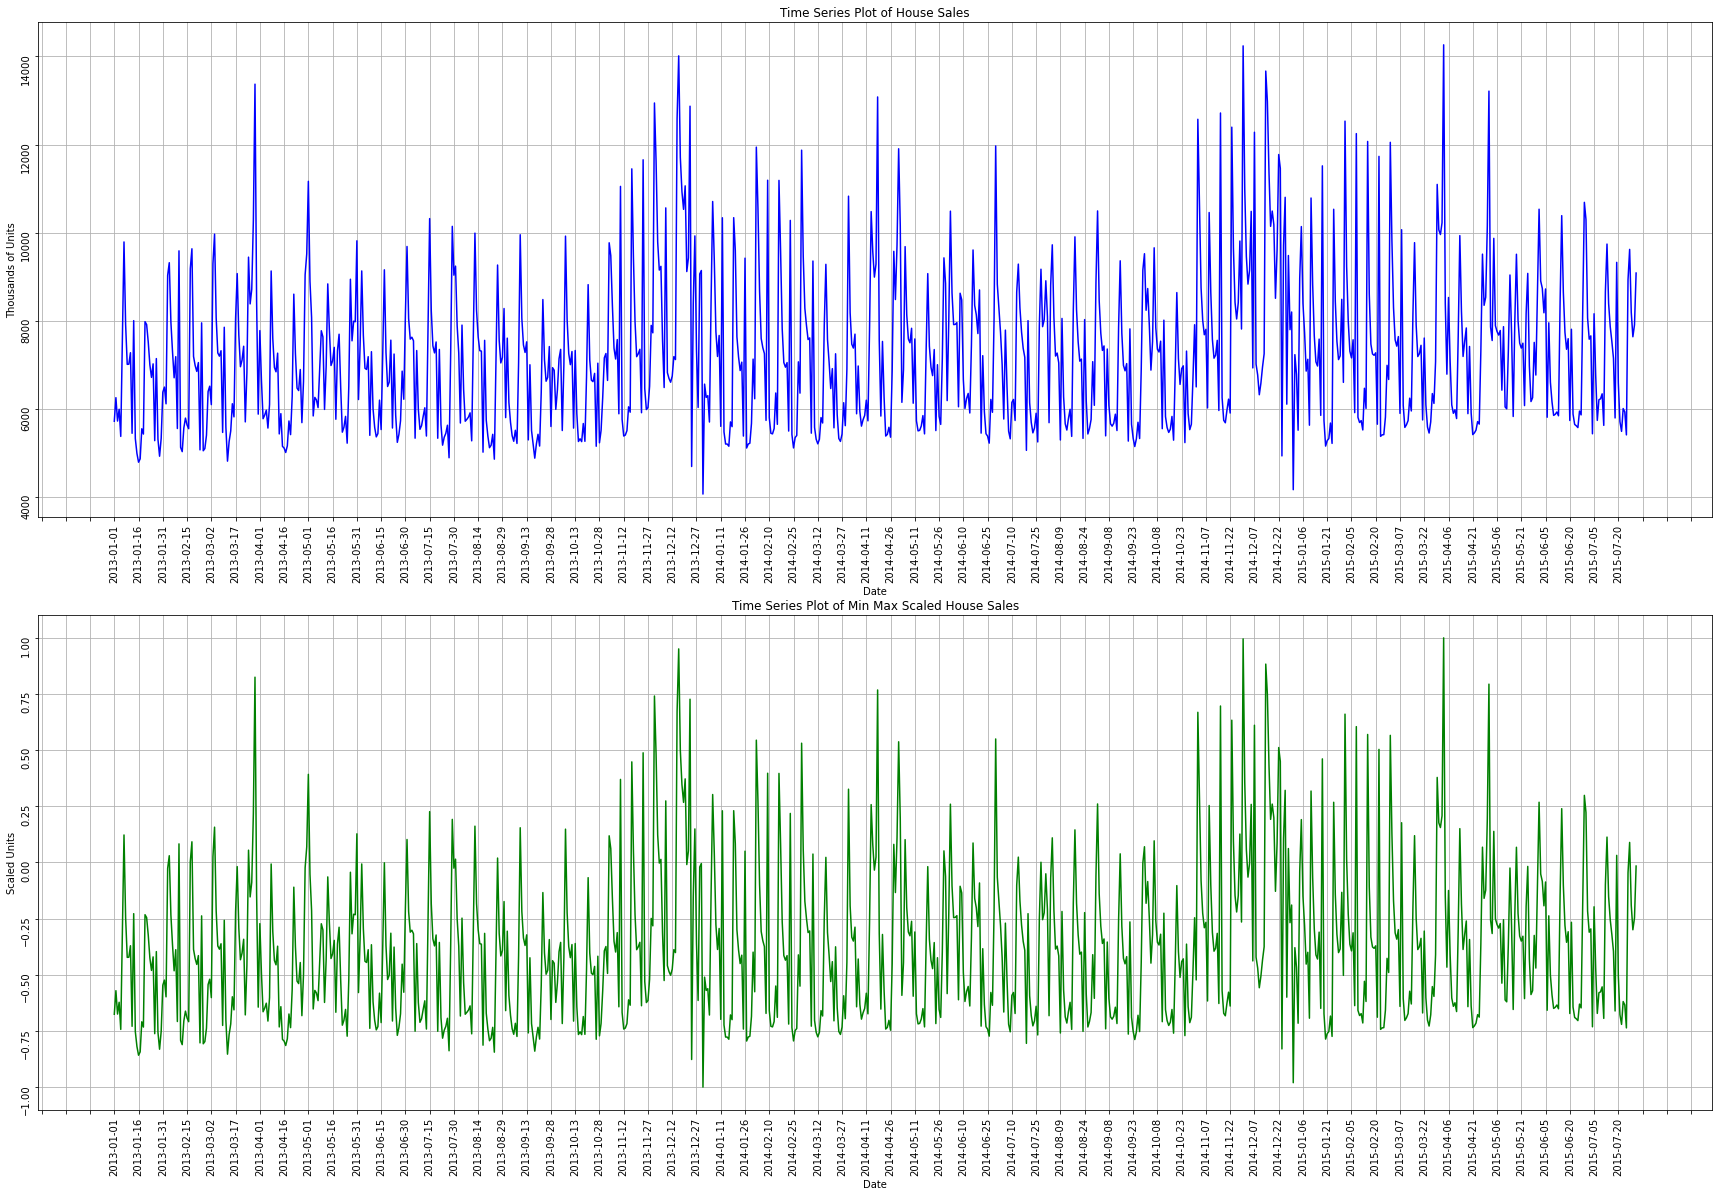

In [37]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(20)
fig.set_figwidth(30)
fig.tight_layout(pad=15)

M = 100
xticks = ticker.MaxNLocator(M)

ax1 = fig.add_subplot(gs[0,0])
ax1.plot(sales.index, sales.Sales, 'b-')
ax1.xaxis.set_major_locator(xticks)
ax1.tick_params(labelrotation=90)
ax1.set_xlabel('Date')
ax1.set_ylabel('Thousands of Units')
ax1.title.set_text('Time Series Plot of House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.plot(sales.index, sales.SalesScaled, 'g-')
ax2.xaxis.set_major_locator(xticks)
ax2.tick_params(labelrotation=90)
ax2.set_xlabel('Date')
ax2.set_ylabel('Scaled Units')
ax2.title.set_text('Time Series Plot of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

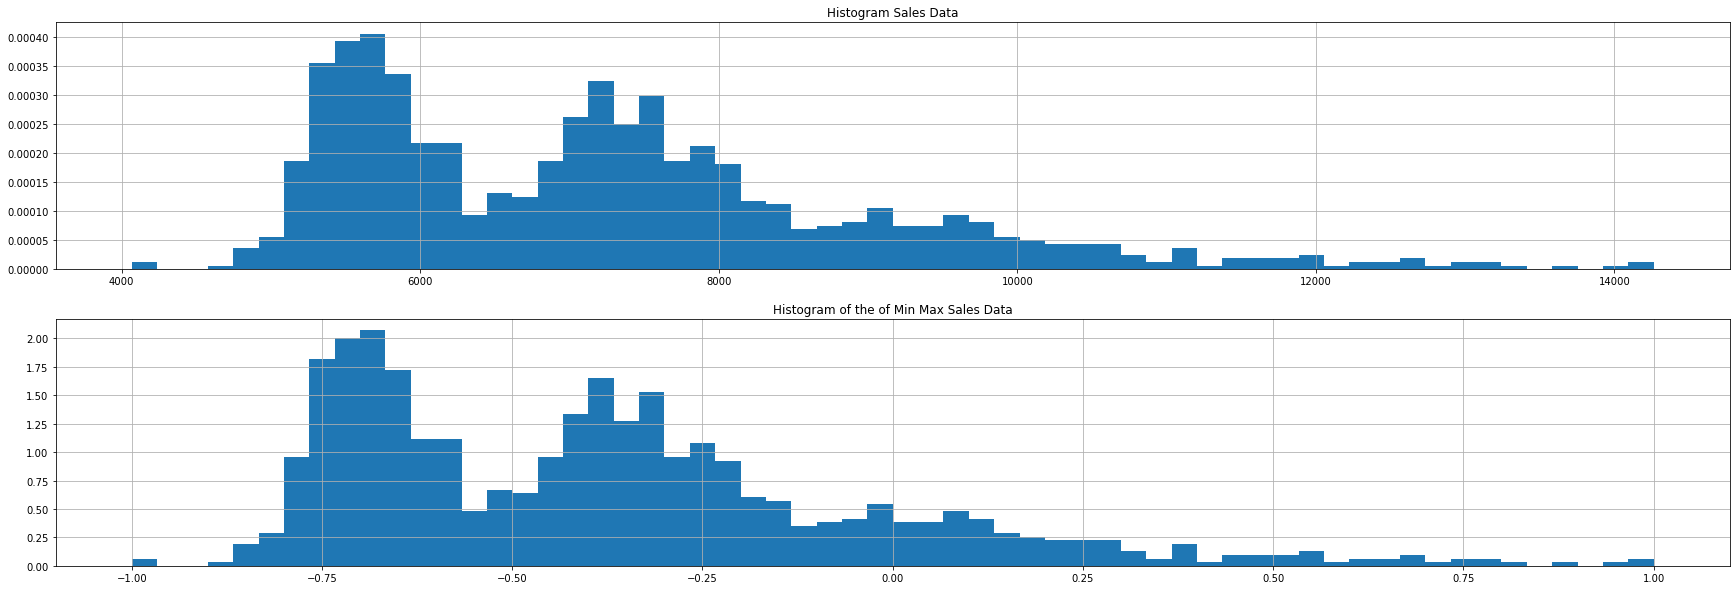

In [65]:
fig = plt.figure()
gs = GridSpec(2, 1, figure=fig)

fig.set_figheight(10)
fig.set_figwidth(30)
fig.tight_layout(pad=6)

ax1 = fig.add_subplot(gs[0,0])
ax1.hist(sales.Sales, density=True, bins=60)
ax1.title.set_text('Histogram House Sales')
ax1.grid(True)

ax2 = fig.add_subplot(gs[1,0])
ax2.hist(sales.SalesScaled, density=True, bins=60)
ax2.title.set_text('Histogram of the of Min Max Scaled House Sales')
ax2.grid(True)
plt.show()

In [66]:
adfResult = adfuller(sales.Sales.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.415359410427693
p-value: 3.1444735831306694e-06


In [67]:
adfResult = adfuller(sales.SalesScaled.values, autolag='AIC')
print(f'ADF Statistic: {adfResult[0]}')
print(f'p-value: {adfResult[1]}')

ADF Statistic: -5.415359410427682
p-value: 3.1444735831308316e-06


In [68]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [69]:
houseSalesDif = difference(sales.SalesScaled.values)

In [70]:
houseSalesDif

0      0.104943
1     -0.104158
2      0.052570
3     -0.120832
4      0.431149
         ...   
936    0.134759
937   -0.280502
938   -0.108474
939    0.052766
940    0.230875
Length: 941, dtype: float64

In [89]:
acfSalesScaled = acf(sales.SalesScaled.values, fft=True, nlags=45)
acfSalesScaledNp = np.array(acfSalesScaled)

In [90]:
def corrPlots(array: np.array, prefix: str):
    plt.figure(figsize=(30, 5))
    plt.title(f"{prefix}  Autocorrelations of House Sales Min Max Scaled")
    plt.bar(range(len(array)), array)
    plt.grid(True)
    plt.show()

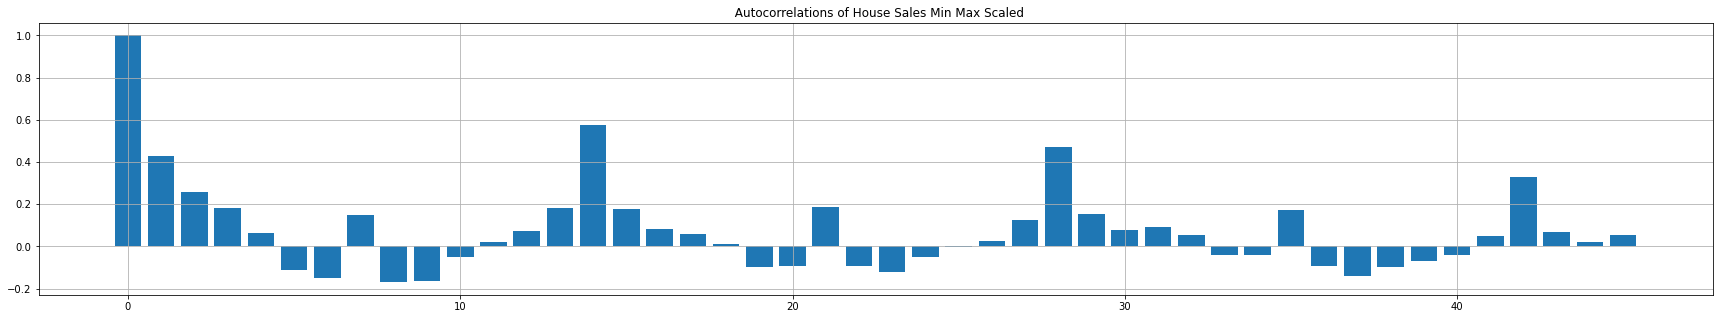

In [91]:
corrPlots(acfSalesScaledNp, '')

In [92]:
pacfSalesScaled = pacf(sales.SalesScaled.values, nlags=45)
pacfSalesScaledNp = np.array(pacfSalesScaled)

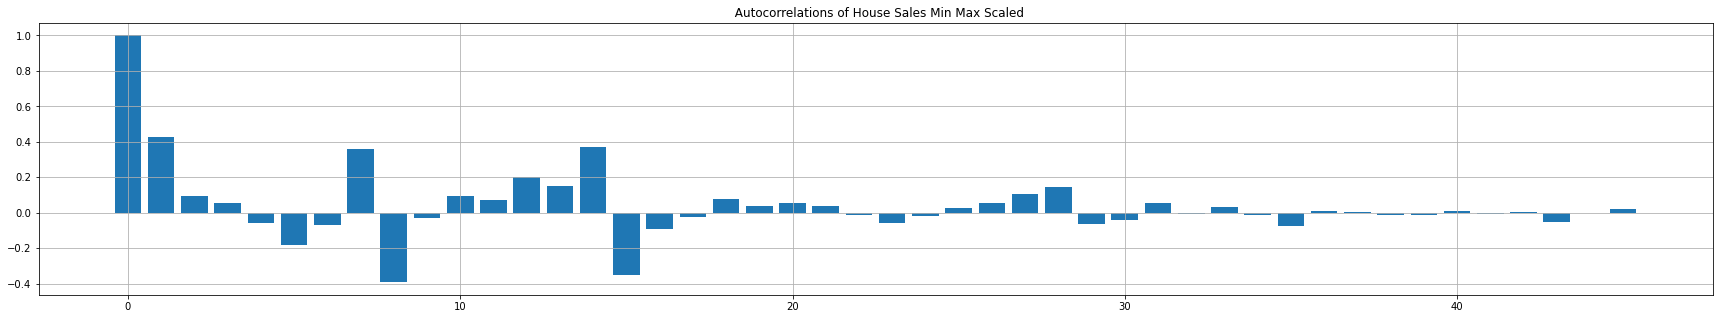

In [93]:
corrPlots(pacfSalesScaledNp, '')

In [129]:
SIZE = len(sales.Sales)
WINDOW_SIZE = 100
BATCH_SIZE= SIZE-WINDOW_SIZE*2
EPOCHS = 300

In [130]:
DateTrain = sales.index.values[0:BATCH_SIZE]
DateValid = sales.index.values[BATCH_SIZE:]
XTrain = sales.SalesScaled.values[0:BATCH_SIZE].astype('float32')
XValid = sales.SalesScaled.values[BATCH_SIZE:].astype('float32')

# Obtain shapes for vectors of size (,1) for dates series

DateTrain = np.reshape(DateTrain, (-1, 1))
DateValid = np.reshape(DateValid, (-1, 1))

print("Shape of the training set date series: ", DateTrain.shape)
print("Shape of the validation set date series: ", DateValid.shape)
print()
print("Shape of the training set logarithm of sales series: ", XTrain.shape)
print("Shape of the validation set logarithm of sales series in a stateless LSTM: ", XValid.shape)

Shape of the training set date series:  (742, 1)
Shape of the validation set date series:  (200, 1)

Shape of the training set logarithm of sales series:  (742,)
Shape of the validation set logarithm of sales series in a stateless LSTM:  (200,)


In [131]:
tf.random.set_seed(1234)
# add extra dimension
# series = tf.expand_dims(XTrain, axis=-1)
# series.shape

In [132]:
def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE): 
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) 
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [133]:
DatasetTrain = windowed_dataset(XTrain)
DatasetVal = windowed_dataset(XValid)

In [134]:
import mlflow.tensorflow
mlflow.tensorflow.autolog(every_n_iter=2,log_models=True)

In [136]:

mlflow.end_run()
with mlflow.start_run(run_name="Lstm_model"):
    model = Sequential()
    model.add(LSTM(8, input_shape=[None, 1], return_sequences=True))
    model.add(LSTM(4, input_shape=[None, 1]))
    model.add(Dense(1))
    model.compile(loss="mean_squared_error", optimizer='adam',metrics=["mean_absolute_error","mean_squared_error"])
    history = model.fit(DatasetTrain, epochs=EPOCHS, validation_data=DatasetVal, verbose=0)
    

mlflow.end_run()

In [ ]:
# mlflow.tensorflow.log_model(model)

In [137]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, None, 8)           320       
_________________________________________________________________
lstm_19 (LSTM)               (None, 4)                 208       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 5         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


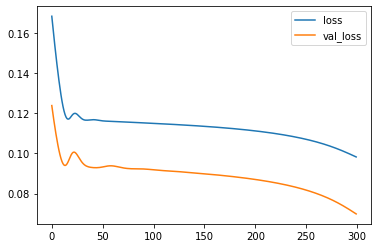

In [138]:
fig = plt.figure()
plt.plot(history.history['loss'], label="loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [139]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True) 
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(SIZE).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [140]:
Forecast = model_forecast(model, sales.SalesScaled.values[:, np.newaxis], WINDOW_SIZE)
Results = Forecast[BATCH_SIZE-WINDOW_SIZE:-1]
Results1 = scaler.inverse_transform(Results.reshape(-1,1))
XValid1 = scaler.inverse_transform(XValid.reshape(-1,1))

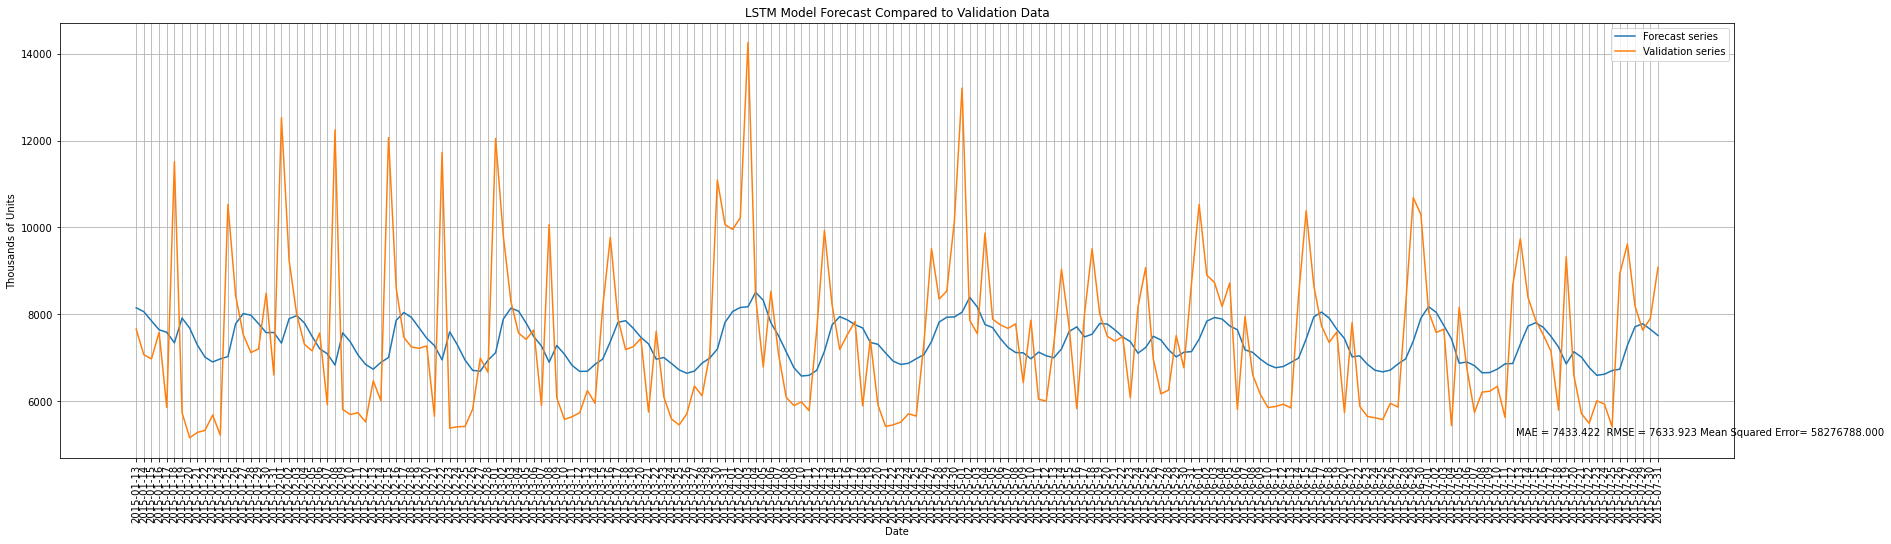

In [141]:
plt.figure(figsize=(30, 8))
plt.title("LSTM Model Forecast Compared to Validation Data")
plt.plot(DateValid.astype('datetime64'), Results1, label='Forecast series')
plt.plot(DateValid.astype('datetime64'), np.reshape(XValid1, (2*WINDOW_SIZE, 1)), label='Validation series')
plt.xlabel('Date')
plt.ylabel('Thousands of Units')
plt.xticks(DateValid.astype('datetime64')[:,-1], rotation = 90) 
plt.legend(loc="upper right")

MAE = tf.keras.metrics.mean_absolute_error(XValid1[:,-1], Results[:,-1]).numpy()
RMSE = np.sqrt(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

textstr = "MAE = " + "{:.3f}".format(MAE) + "  RMSE = " + "{:.3f}".format(RMSE)+ " Mean Squared Error= ""{:.3f}".format(tf.keras.metrics.mean_squared_error(XValid1[:,-1], Results[:,-1]).numpy())

# place a text box in upper left in axes coords
plt.annotate(textstr, xy=(0.87, 0.05), xycoords='axes fraction')
plt.grid(True)

plt.show()

In [142]:
print(textstr)

MAE = 7433.422  RMSE = 7633.923 Mean Squared Error= 58276788.000
